##Тестовое задание для компании Chem Tech

Используя данные представленные по ссылке Train_Data_200k создать модель, нацеленную на прогнозирование значений параметров Target_1...4 по значениям Tag_1...79.
После получения модели применить ее к тестовой выборке представленной в архиве ML_Data в файле test_data_100k и на основании значений Tag_1...79 получить прогнозы для параметров Target_1...4.
Полученные прогнозы и топ-10 значимых тэгов направить в качестве результата в ответном письме.
Вложить рабочую тетрадь
Ссылка для скачивания:

Исходные данные
https://drive.google.com/drive/folders/1lI8_Q6cFMQnVO0oU3YeHw30JEqdiq0hb?usp=sharing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import catboost as cb
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor


In [ ]:
!unzip -q /content/drive/MyDrive/Chem_Tech_AI/train_test_data.zip -d /content/data

In [ ]:
df_train = pd.read_csv("data/train_data_200k.csv")
df_test = pd.read_csv("data/test_data_100k.csv")

## Проведем базовый анализ данных: выведем размерность датасетов, посчитаем базовые статистики, выполним анализ пропусков;

In [ ]:
df_train.head(n=5)

,Unnamed: 0,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,tag10,tag11,tag12,tag13,tag14,tag15,tag16,tag17,tag18,tag19,tag20,tag21,tag22,tag23,tag24,tag25,tag26,tag27,tag28,tag29,tag30,tag31,tag32,tag33,tag34,tag35,tag36,tag37,tag38,tag39,...,tag44,tag45,tag46,tag47,tag48,tag49,tag50,tag51,tag52,tag53,tag54,tag55,tag56,tag57,tag58,tag59,tag60,tag61,tag62,tag63,tag64,tag65,tag66,tag67,tag68,tag69,tag70,tag71,tag72,tag73,tag74,tag75,tag76,tag77,tag78,tag79,target1,target2,target3,target4
0,2016-08-18 00:00:00,15.78042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.30402,60.01311,-0.001269,0.018163,-0.000183,0.000671,0.000956,0.000858,0.000992,NaN,19.26714,22.33068,15.60123,80.97660,22.33527,33.87122,24.00339,57.06384,44.54309,23.80796,27.63220,47.27997,23.96099,23.94522,26.39192,47.87158,37.12356,36.37045,NaN,67.60985,...,NaN,NaN,NaN,183.3191,206.6534,69.99840,NaN,NaN,50.50632,46.30415,61.20765,72.77773,25.30402,60.01311,2.373747,0.677581,2.775156,1.769055,2.766034,2.794747,33.42513,34.27024,39.65590,44.48986,50.34106,37.34515,53.65030,50.70506,61.08673,72.76518,53.02723,66.30531,55.10297,73.65612,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-08-18 00:01:00,15.80157,NaN,NaN,NaN,NaN,NaN,53.06440,NaN,NaN,25.30464,60.01566,-0.001289,0.018208,-0.000210,0.000670,0.000947,0.000857,0.001003,25.31277,19.26205,22.35979,15.61021,80.98914,22.33696,33.89564,23.99264,57.05022,44.49367,23.81503,27.63496,47.27994,23.97050,23.93777,26.40619,47.86334,37.09820,36.26917,NaN,NaN,...,NaN,NaN,NaN,185.1547,205.3378,69.98409,NaN,NaN,50.49541,46.20826,61.20348,72.76062,25.30464,60.01566,2.373543,0.677852,2.775152,1.769295,2.766190,2.794963,33.41073,34.25732,39.70995,44.46941,50.31259,37.34732,53.65897,50.60955,61.09685,72.76947,53.05109,66.30098,55.11534,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-08-18 00:02:00,15.68913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.30486,60.01267,-0.001310,0.018185,-0.000146,0.000663,0.000957,0.000855,0.001004,NaN,19.26793,22.38500,15.59624,80.94573,22.33768,33.91651,23.98789,57.04745,44.52599,23.81206,27.63683,47.24675,23.96895,23.92040,26.36558,47.87779,37.10657,36.28939,91.98822,67.92857,...,NaN,NaN,NaN,185.7857,206.4609,70.04832,NaN,NaN,50.49607,46.24781,61.20309,72.76160,25.30486,60.01267,2.373388,0.677734,2.775619,1.768982,2.766650,2.795123,33.41452,34.23959,39.74942,44.45711,50.31557,37.32831,53.66189,50.60200,61.05627,72.75539,53.06495,66.30359,55.09395,NaN,NaN,55.07365,NaN,NaN,NaN,NaN
3,2016-08-18 00:03:00,15.75101,NaN,20.26209,NaN,NaN,NaN,52.95166,NaN,NaN,25.30544,60.01596,-0.000885,0.018180,-0.000192,0.000672,0.000949,0.000864,0.001003,NaN,19.24153,22.34216,15.60701,80.93867,22.33434,33.98246,23.98795,57.05103,44.51584,23.80859,27.62737,47.26019,23.94341,23.91153,26.39959,47.91307,37.14546,36.27222,NaN,NaN,...,NaN,NaN,NaN,182.6789,207.5279,69.95206,37.13296,NaN,50.51320,46.13975,61.28067,72.77470,25.30544,60.01596,2.385501,0.678970,2.775364,1.769024,2.766515,2.795122,33.40705,34.23381,39.79846,44.47630,50.28574,37.30737,53.67104,50.68343,61.00186,72.77387,53.06760,66.28421,55.12513,NaN,92.46913,NaN,NaN,NaN,NaN,NaN
4,2016-08-18 00:04:00,15.57773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.30540,60.01478,-0.001005,0.018167,-0.000113,0.000678,0.000955,0.000865,0.001013,NaN,19.25176,22.33690,15.60543,80.97723,22.33530,34.05027,23.98389,57.05997,44.51775,23.76636,27.64237,47.20809,23.93508,23.90270,26.37914,47.93106,37.13568,36.26667,NaN,NaN,...,NaN,NaN,NaN,186.6251,NaN,69.99007,NaN,NaN,50.50373,46.33209,61.28010,72.72731,25.30540,60.01478,2.385056,0.678937,2.775762,1.769598,2.766815,2.795541,33.37688,34.22705,39.81411,44.48069,50.23417,37.30698,53.58812,50.64983,61.04366,72.72121,53.09679,66.26472,55.15526,73.67016,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_train.describe()

,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,tag10,tag11,tag12,tag13,tag14,tag15,tag16,tag17,tag18,tag19,tag20,tag21,tag22,tag23,tag24,tag25,tag26,tag27,tag28,tag29,tag30,tag31,tag32,tag33,tag34,tag35,tag36,tag37,tag38,tag39,tag40,...,tag44,tag45,tag46,tag47,tag48,tag49,tag50,tag51,tag52,tag53,tag54,tag55,tag56,tag57,tag58,tag59,tag60,tag61,tag62,tag63,tag64,tag65,tag66,tag67,tag68,tag69,tag70,tag71,tag72,tag73,tag74,tag75,tag76,tag77,tag78,tag79,target1,target2,target3,target4
count,1.999340e+05,109370.000000,109456.000000,85.000000,9736.000000,373.000000,88122.000000,16777.000000,407.000000,199837.000000,199867.000000,199875.000000,199875.000000,199875.000000,199875.000000,199875.000000,199875.000000,199875.000000,100168.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,39220.000000,38048.000000,1.583080e+05,152970.000000,15578.000000,...,1.117250e+05,1.138000e+05,98410.0,1.998670e+05,132355.000000,199866.000000,78120.000000,14722.000000,101792.000000,84189.000000,59443.000000,199867.000000,199837.000000,199867.000000,199837.000000,199119.000000,199875.000000,35810.000000,36726.000000,199875.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,37652.000000,199867.000000,199867.000000,199867.000000,35087.000000,199867.000000,199867.000000,199867.000000,48803.000000,48673.000000,48558.000000,199991.000000,199991.000000,199991.000000,199991.000000
mean,1.471747e+01,0.003483,12.696579,9.101270,31.654650,68.328355,47.680708,46.703799,71.668521,23.584873,50.128928,-0.000334,0.009145,-0.001012,0.000952,0.000641,0.000594,0.001458,20.305728,11.696598,13.797841,11.759747,81.016135,19.222866,8.782267,10.878145,20.160856,17.093377,25.379681,26.202377,20.609791,5.374740,19.468993,10.680114,23.355227,35.503725,34.075806,7.990204e+01,59.421573,40.916190,...,1.761049e+01,1.316814e+00,0.0,1.848092e+02,245.337823,69.513164,43.837855,45.891781,46.728568,46.626250,59.817989,72.660003,23.584873,50.128928,2.415533,0.716383,2.769036,1.769548,2.763237,2.793360,20.816438,26.055005,28.467759,43.801585,38.095371,35.714963,43.459269,50.051799,56.016110,72.578699,41.898820,66.520646,53.966135,75.458923,94.800765,55.872240,0.001156,0.049836,0.942428,0.006580
std,1.873427e+00,0.017229,4.285856,9.667475,5.039073,13.580792,4.506643,3.940905,0.606023,4.877921,16.948128,0.002746,0.006391,0.000964,0.000167,0.000156,0.000138,0.000478,4.028258,6.351744,6.973005,5.400680,0.562162,13.288055,19.251651,9.765605,29.312477,23.205521,15.660261,11.451187,25.272481,14.370803,9.534630,15.769529,21.636223,3.704882,4.235066,5.119445e+00,3.839873,2.699708,...,3.041737e+00,9.415702e-01,0.0,6.731712e+00,18.389717,4.449915,3.705196,3.696100,3.468820,2.981598,3.227836,0.214569,4.877921,16.948128,0.186903,0.179985,0.036395,0.003708,0.008499,0.007465,11.133341,3.790688,7.818537,1.117651,8.392762,3.534464,7.486956,1.536693,4.041327,0.235175,7.772574,0.392989,1.512331,0.872953,2.888815,1.450305,0.000085,0.003685,0.003936,0.001442
min,2.215690e-08,-0.005142,0.008831,-3.354573,15.898870,10.271640,22.730830,24.820300,69.825200,8.848302,-0.050376,-0.030081,-0.003332,-0.002694,0.000252,0.000161,0.000170,0.000683,0.000000,-10.558860,-9.543885,-19.495170,68.816150,-7.698016,-34.570690,-14.961360,-34.654410,-30.909190,-4.582263,2.232100,-29.993390,-37.930990,-6.355927,-34.072190,-21.258420,18.954950,15.042280,6.259399e-07,0.020922,20.059580,...,2.313189e-25,2.303353e-25,0.0,6.076754e-19,0.000218,19.210710,22.781390,28.341410,24.284860,27.575620,37.753350,67.914190,8.848302,-0.050376,1.947665,-0.000511,0.000097,1.703969,2.574159,2.599954,0.000000,15.118610,-4.038994,33.356780,18.640790,18.862820,23.278410,40.573780,43.124100,67.901700,23.078610,62.552550,44.860980,71.780270,90.015210,46.590670,0.000826,0.035611,0.912861,0.002595
25%,1.359252e+01,0.001326,8.111923,4.375712,28.884520,71.9185

In [ ]:
df_test.head(n=5)

,Unnamed: 0,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,tag10,tag11,tag12,tag13,tag14,tag15,tag16,tag17,tag18,tag19,tag20,tag21,tag22,tag23,tag24,tag25,tag26,tag27,tag28,tag29,tag30,tag31,tag32,tag33,tag34,tag35,tag36,tag37,tag38,tag39,tag40,tag41,tag42,tag43,tag44,tag45,tag46,tag47,tag48,tag49,tag50,tag51,tag52,tag53,tag54,tag55,tag56,tag57,tag58,tag59,tag60,tag61,tag62,tag63,tag64,tag65,tag66,tag67,tag68,tag69,tag70,tag71,tag72,tag73,tag74,tag75,tag76,tag77,tag78,tag79
0,2017-01-03 21:21:00,12.59972,NaN,NaN,NaN,NaN,NaN,45.27993,43.13644,NaN,18.52599,39.32740,-0.000455,0.008434,-0.002304,0.001122,0.000523,0.000486,0.001575,15.60314,5.786203,3.869510,26.24795,80.58496,-1.582004,-3.424408,-3.334276,-3.876192,-1.179340,1.146502,5.792550,-1.916306,13.43756,-0.585351,40.78546,2.505804,NaN,NaN,86.76460,64.90110,NaN,NaN,16.46412,145.2561,17.68695,3.026593,0.0,175.3113,245.8068,61.43165,NaN,NaN,42.42581,NaN,NaN,72.65778,18.52599,39.32740,2.458516,0.474685,2.768988,NaN,NaN,2.788620,24.54365,24.18768,23.33983,33.42708,33.96873,NaN,37.63644,40.64410,53.44470,NaN,36.59567,64.47523,45.08920,NaN,NaN,NaN
1,2017-01-03 21:22:00,12.65850,NaN,NaN,NaN,NaN,NaN,NaN,42.98455,NaN,18.52530,39.33560,-0.000480,0.008442,-0.002240,0.001128,0.000534,0.000485,0.001583,15.55087,5.781599,3.960081,26.23933,80.56205,-1.584656,-3.423789,-3.336082,-3.876512,-1.203795,1.156482,5.778395,-1.918682,13.76316,-0.599309,40.67742,2.493002,NaN,NaN,85.89352,64.45879,NaN,NaN,16.45829,144.6648,17.82857,2.992872,0.0,178.0342,246.3277,61.52076,36.99681,NaN,42.72885,NaN,NaN,72.67284,18.52530,39.33560,2.457176,0.474681,2.769368,NaN,NaN,2.789062,24.54758,24.17372,23.37887,33.51478,33.99389,NaN,37.69201,40.68030,53.43953,NaN,36.60715,64.48697,45.18127,NaN,NaN,NaN
2,2017-01-03 21:23:00,12.69538,NaN,NaN,NaN,NaN,NaN,NaN,41.87401,NaN,18.52505,39.33189,-0.000564,0.008445,-0.002268,0.001129,0.000529,0.000486,0.001583,15.56572,5.808495,3.943974,26.26303,80.56678,-1.595108,-3.421828,-3.346181,-3.867854,-1.194099,1.155884,5.795678,-1.918225,14.24844,-0.603250,40.87209,2.482313,NaN,NaN,85.99540,64.29038,NaN,NaN,16.46561,144.5803,17.89324,3.022128,0.0,176.1473,245.7588,61.44187,37.06912,NaN,NaN,47.41304,NaN,72.67111,18.52505,39.33189,2.457504,0.474712,2.769572,NaN,NaN,2.789292,24.59129,24.19185,23.34789,33.45205,33.97408,NaN,37.71147,40.69286,53.42733,NaN,36.60194,64.48034,45.00529,75.84169,NaN,NaN
3,2017-01-03 21:24:00,12.84726,NaN,NaN,NaN,NaN,NaN,NaN,41.78006,NaN,18.52450,39.33465,-0.000569,0.008432,-0.002256,0.001152,0.000536,0.000488,0.001585,15.55563,5.826701,4.027435,26.29115,80.54873,-1.592608,-3.416253,-3.338829,-3.874055,-1.193421,1.138407,5.743540,-1.939878,14.40530,-0.603368,41.17179,2.490955,NaN,NaN,86.40989,64.54041,NaN,NaN,16.49379,144.7347,17.87374,3.033943,0.0,176.5516,246.0970,61.48563,37.14243,47.55349,NaN,NaN,NaN,72.67953,18.52450,39.33465,2.458431,0.474522,2.769539,NaN,NaN,2.789257,24.58162,24.16452,23.39324,33.39526,33.98973,NaN,37.70427,40.61716,53.44097,NaN,36.61879,64.50220,45.10987,NaN,93.62097,NaN
4,2017-01-03 21:25:00,12.98246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.52613,39.33673,-0.000699,0.008418,-0.002248,0.001126,0.000528,0.000476,0.001585,15.56986,5.784142,4.020133,26.27498,80.54944,-1.601977,-3.419028,-3.345777,-3.884507,-1.183772,1.123753,5.751623,-1.960477,14.44620,-0.615406,41.35782,2.474082,NaN,NaN,86.50966,64.28045,NaN,NaN,16.47419,143.7957,17.77529,3.002159,0.0,177.5667,246.1794,61.42502,36.30262,NaN,NaN,47.13390,NaN,72.69955,18.52613,39.33673,2.471320,0.470062,2.768945,NaN,NaN,2.788598,24.58673,24.18369,23.40569,33.49465,34.00968,NaN,37.69343,40.64507,53.51237,NaN,36.59875,64.48300,45.12246,NaN,NaN,56.14647


In [ ]:
all_features = df_train.columns
all_features

Index(['Unnamed: 0', 'tag1', 'tag2', 'tag3', 'tag4', 'tag5', 'tag6', 'tag7',
       'tag8', 'tag9', 'tag10', 'tag11', 'tag12', 'tag13', 'tag14', 'tag15',
       'tag16', 'tag17', 'tag18', 'tag19', 'tag20', 'tag21', 'tag22', 'tag23',
       'tag24', 'tag25', 'tag26', 'tag27', 'tag28', 'tag29', 'tag30', 'tag31',
       'tag32', 'tag33', 'tag34', 'tag35', 'tag36', 'tag37', 'tag38', 'tag39',
       'tag40', 'tag41', 'tag42', 'tag43', 'tag44', 'tag45', 'tag46', 'tag47',
       'tag48', 'tag49', 'tag50', 'tag51', 'tag52', 'tag53', 'tag54', 'tag55',
       'tag56', 'tag57', 'tag58', 'tag59', 'tag60', 'tag61', 'tag62', 'tag63',
       'tag64', 'tag65', 'tag66', 'tag67', 'tag68', 'tag69', 'tag70', 'tag71',
       'tag72', 'tag73', 'tag74', 'tag75', 'tag76', 'tag77', 'tag78', 'tag79',
       'target1', 'target2', 'target3', 'target4'],
      dtype='object')

## Анализ числовых признаков

In [ ]:
numerical_features = df_train.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features.shape[1]}")

numerical_features.columns

count of numeric_features 83


Index(['tag1', 'tag2', 'tag3', 'tag4', 'tag5', 'tag6', 'tag7', 'tag8', 'tag9',
       'tag10', 'tag11', 'tag12', 'tag13', 'tag14', 'tag15', 'tag16', 'tag17',
       'tag18', 'tag19', 'tag20', 'tag21', 'tag22', 'tag23', 'tag24', 'tag25',
       'tag26', 'tag27', 'tag28', 'tag29', 'tag30', 'tag31', 'tag32', 'tag33',
       'tag34', 'tag35', 'tag36', 'tag37', 'tag38', 'tag39', 'tag40', 'tag41',
       'tag42', 'tag43', 'tag44', 'tag45', 'tag46', 'tag47', 'tag48', 'tag49',
       'tag50', 'tag51', 'tag52', 'tag53', 'tag54', 'tag55', 'tag56', 'tag57',
       'tag58', 'tag59', 'tag60', 'tag61', 'tag62', 'tag63', 'tag64', 'tag65',
       'tag66', 'tag67', 'tag68', 'tag69', 'tag70', 'tag71', 'tag72', 'tag73',
       'tag74', 'tag75', 'tag76', 'tag77', 'tag78', 'tag79', 'target1',
       'target2', 'target3', 'target4'],
      dtype='object')

## Переменные, связанные со временем

In [ ]:
year_feature = ["Unnamed: 0"]

In [ ]:
type(df_train["Unnamed: 0"][1])

str

In [ ]:
df_train[year_feature][:5]

,Unnamed: 0
0,2016-08-18 00:00:00
1,2016-08-18 00:01:00
2,2016-08-18 00:02:00
3,2016-08-18 00:03:00
4,2016-08-18 00:04:00


Посмотрим где прерывается временной период в обучающей выборке и начинается тренировочная

In [ ]:
df_train[year_feature][-1:]

,Unnamed: 0
199999,2017-01-03 21:19:00


In [ ]:
df_test[year_feature][:1]

,Unnamed: 0
0,2017-01-03 21:21:00


Здесь только один признак связанный со временем. Сразу бросается в глаза интервал в одну минуту

## Дискретные признаки

In [ ]:
discrete_feature = [
    feature for feature in numerical_features
    # if len(df_train[feature].unique())<25 and feature not in year_feature+["Id"]
    if len(df_train[feature].unique())<25
]

print(f"Discrete Variables Count: {len(discrete_feature)}")
print(f"Discrete Variables Column: {discrete_feature}")

Discrete Variables Count: 1
Discrete Variables Column: ['tag46']


In [ ]:
df_train[discrete_feature].head(n=5)

,tag46
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


Дискретные признаки не найдены. Найденный признак пустой, думаю от него не будет никакой пользы при обучении.

## Непрерывные признаки

In [ ]:
continuous_feature = [
    feature for feature in numerical_features
    # if feature not in discrete_feature + ["Id"] + year_feature
    if feature not in discrete_feature + ["Id"]
    ]

print(f"Continuous Feature Count {len(continuous_feature)}")

Continuous Feature Count 82


In [ ]:
print(continuous_feature)

['tag1', 'tag2', 'tag3', 'tag4', 'tag5', 'tag6', 'tag7', 'tag8', 'tag9', 'tag10', 'tag11', 'tag12', 'tag13', 'tag14', 'tag15', 'tag16', 'tag17', 'tag18', 'tag19', 'tag20', 'tag21', 'tag22', 'tag23', 'tag24', 'tag25', 'tag26', 'tag27', 'tag28', 'tag29', 'tag30', 'tag31', 'tag32', 'tag33', 'tag34', 'tag35', 'tag36', 'tag37', 'tag38', 'tag39', 'tag40', 'tag41', 'tag42', 'tag43', 'tag44', 'tag45', 'tag47', 'tag48', 'tag49', 'tag50', 'tag51', 'tag52', 'tag53', 'tag54', 'tag55', 'tag56', 'tag57', 'tag58', 'tag59', 'tag60', 'tag61', 'tag62', 'tag63', 'tag64', 'tag65', 'tag66', 'tag67', 'tag68', 'tag69', 'tag70', 'tag71', 'tag72', 'tag73', 'tag74', 'tag75', 'tag76', 'tag77', 'tag78', 'tag79', 'target1', 'target2', 'target3', 'target4']


Для непрерывных признаков построим гистрограммы распределения, а также зависимость непрерывного признака в разрезе целевой переменной.

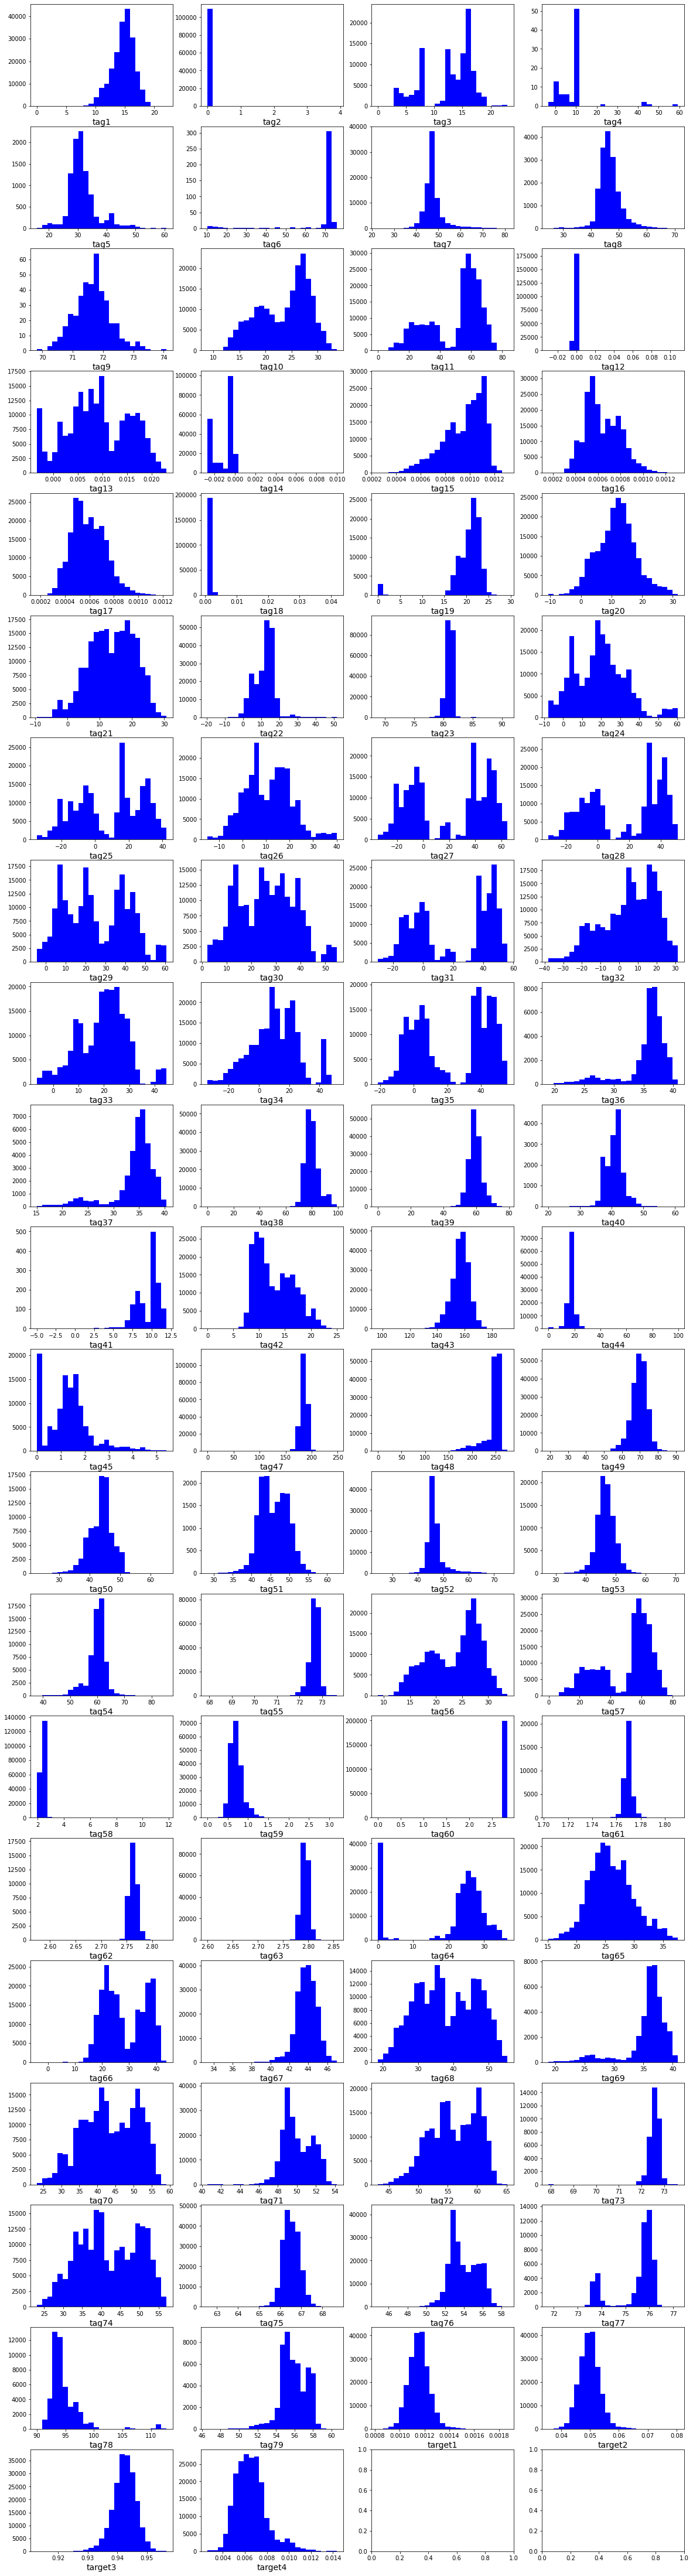

In [ ]:
fig, axes = plt.subplots(21, 4, figsize=(20, 80))

for num, feature in enumerate(continuous_feature):
    data = df_train[feature].copy()
    axes[num//4, num%4].hist(data, bins=25, color="blue")
    axes[num//4, num%4].set_xlabel(feature, fontsize=14)
    

Так же построим распределение одновременно и для обучающей выборки, и для тестовой для понимания насколько отличаются распределения.

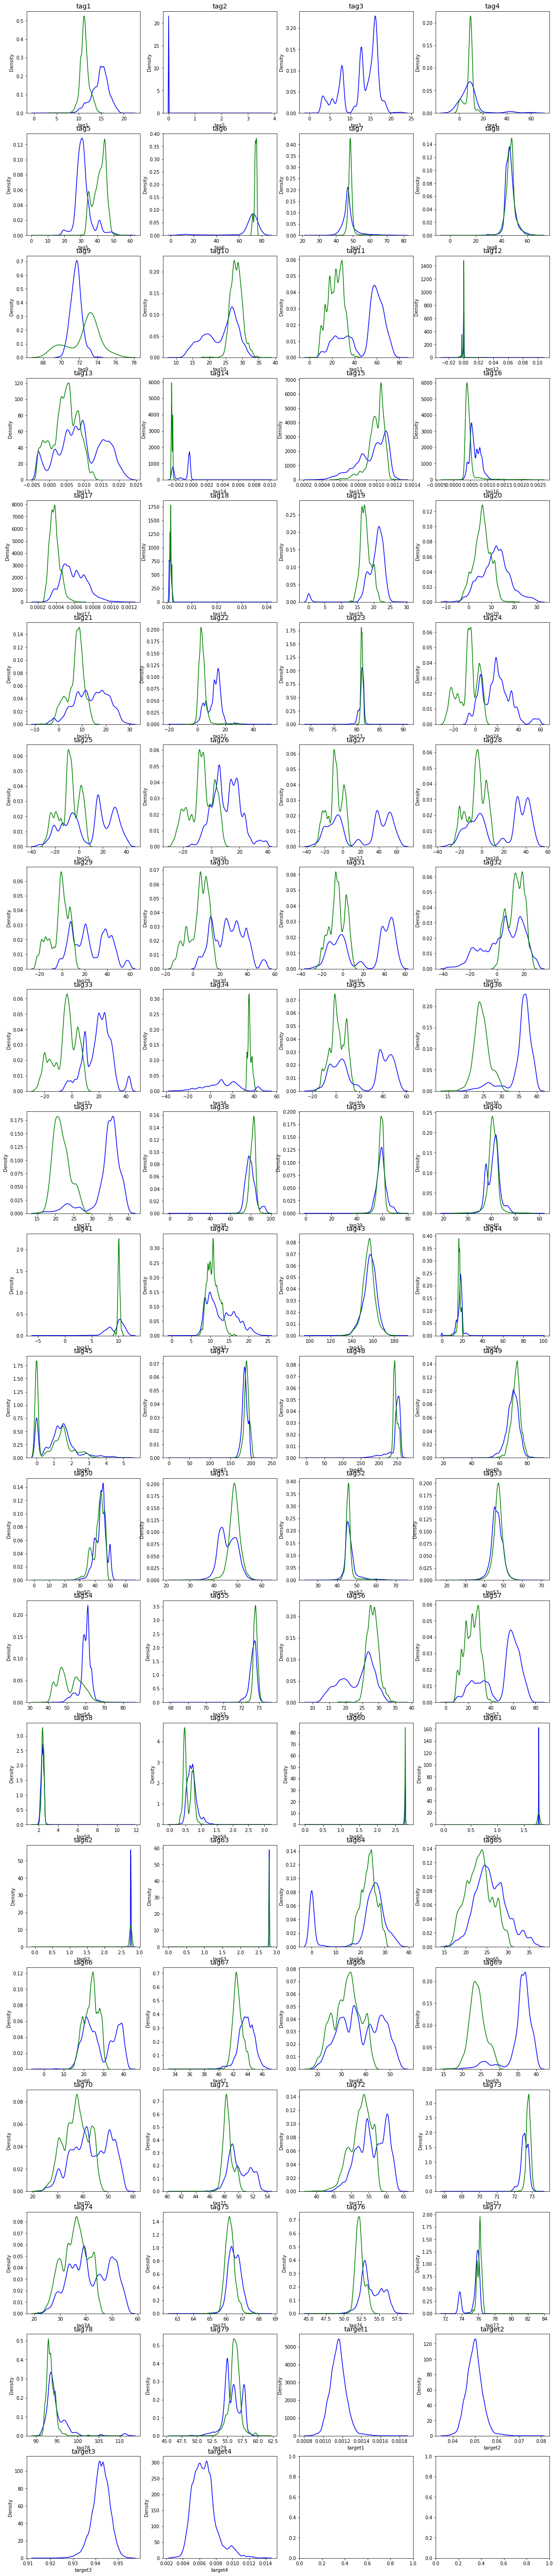

In [ ]:
fig, axes = plt.subplots(21, 4, figsize=(20, 100))

for num, feature in enumerate(continuous_feature):
    try:
        train_data, test_data = df_train[feature].copy(), df_test[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
        sns.kdeplot(test_data, ax=axes[num//4, num%4], color="green", label="test")
    except RuntimeError:
        pass
    except KeyError:
        train_data = df_train[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
    axes[num//4, num%4].set_title(feature, fontsize=14)

## Категориальные признаки

In [ ]:
categorical_features = df_train.select_dtypes(include=[np.object])
print(f"Categorical Feature Count {categorical_features.shape[1]}")
categorical_features.head(n=5)

Categorical Feature Count 1


,Unnamed: 0
0,2016-08-18 00:00:00
1,2016-08-18 00:01:00
2,2016-08-18 00:02:00
3,2016-08-18 00:03:00
4,2016-08-18 00:04:00


Категориальных признаков у нас нет, нашелся только признак связанный с датой.

## Проведем базовый анализ целевых переменных

На предыдущих этапах мы выявили, что целевые переменные у нас непрерывные

In [ ]:
# target1 = df_train["target1"]
# target1.value_counts()

In [ ]:
stats_list = []
for num, feature in enumerate(continuous_feature[:-4]):
    d = {}
    d["feature_name"] = feature
    d["0_std"] = df_train[df_train['target1']==0][feature].std()
    d["1_std"] = df_train[df_train['target1']==1][feature].std()
    d["0_mean"] = df_train[df_train['target1']==0][feature].mean()
    d["1_mean"] = df_train[df_train['target1']==1][feature].mean()
    d["train_mean"] = df_train[feature].mean()
    d["test_mean"] = df_test[feature].mean()
    d["train_std"] = df_train[feature].std()
    d["test_std"] = df_test[feature].std()
    stats_list.append(d)

df_stats_list = pd.DataFrame(stats_list)
df_stats_list

,feature_name,0_std,1_std,0_mean,1_mean,train_mean,test_mean,train_std,test_std
0,tag1,NaN,NaN,NaN,NaN,14.717470,11.301044,1.873427,0.984816
1,tag2,NaN,NaN,NaN,NaN,0.003483,NaN,0.017229,NaN
2,tag3,NaN,NaN,NaN,NaN,12.696579,NaN,4.285856,NaN
3,tag4,NaN,NaN,NaN,NaN,9.101270,8.259843,9.667475,3.282814
4,tag5,NaN,NaN,NaN,NaN,31.654650,41.407615,5.039073,3.911453
...,...,...,...,...,...,...,...,...,...
73,tag75,NaN,NaN,NaN,NaN,66.520646,66.238411,0.392989,0.296024
74,tag76,NaN,NaN,NaN,NaN,53.966135,52.266307,1.512331,0.680044
75,tag77,NaN,NaN,NaN,NaN,75.458923,76.145161,0.872953,0.269156
76,tag78,NaN,NaN,NaN,NaN,94.800765,93.546410,2.888815,1.104953


In [ ]:
df_stats_columns = df_stats_list.columns
df_stats_columns[1:]

Index(['0_std', '1_std', '0_mean', '1_mean', 'train_mean', 'test_mean',
       'train_std', 'test_std'],
      dtype='object')

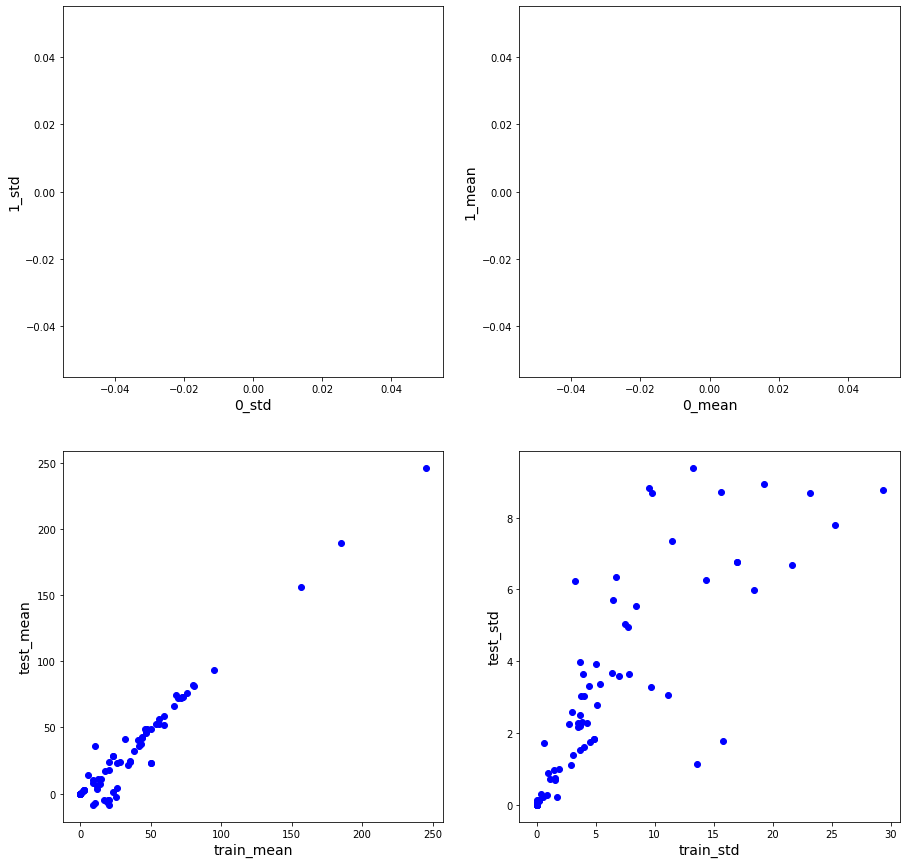

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

num = 0
while num < 4:
  axes[num//2, num%2].scatter(df_stats_list[df_stats_columns[num*2+1]], df_stats_list[df_stats_columns[num*2+2]], color="blue")
  axes[num//2, num%2].set_xlabel(df_stats_columns[num*2+1], fontsize=14)
  axes[num//2, num%2].set_ylabel(df_stats_columns[num*2+2], fontsize=14)
  num += 1

Построим распределение коэффициентов корреляции между признаками. Есть ли зависимость между признаками (будем считать, что связь между признаками отсутствует, если коэффициент корреляции < 0.2)?

In [ ]:
correlation = numerical_features.corr()
corr_with_target_1 = correlation["target1"].sort_values(ascending = False)
corr_with_target_1

target1    1.000000
target2    0.999999
tag49      0.527675
tag1       0.313592
tag5       0.295950
             ...   
tag76     -0.362139
tag67     -0.506179
tag75     -0.551591
target3   -0.930867
tag46           NaN
Name: target1, Length: 83, dtype: float64

In [ ]:
corr_with_target_2 = correlation["target2"].sort_values(ascending = False)
corr_with_target_2

target2    1.000000
target1    0.999999
tag49      0.527664
tag1       0.313595
tag5       0.295880
             ...   
tag76     -0.362138
tag67     -0.506189
tag75     -0.551585
target3   -0.930863
tag46           NaN
Name: target2, Length: 83, dtype: float64

In [ ]:
corr_with_target_3 = correlation["target3"].sort_values(ascending = False)
corr_with_target_3

target3    1.000000
tag75      0.478740
tag67      0.442505
tag19      0.347516
tag76      0.341228
             ...   
tag6      -0.338930
tag49     -0.491400
target2   -0.930863
target1   -0.930867
tag46           NaN
Name: target3, Length: 83, dtype: float64

In [ ]:
corr_with_target_4 = correlation["target4"].sort_values(ascending = False)
corr_with_target_4

target4    1.000000
tag59      0.865138
tag6       0.257247
tag43      0.186662
tag23      0.152994
             ...   
tag10     -0.186425
tag56     -0.186425
tag44     -0.210767
target3   -0.295557
tag46           NaN
Name: target4, Length: 83, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

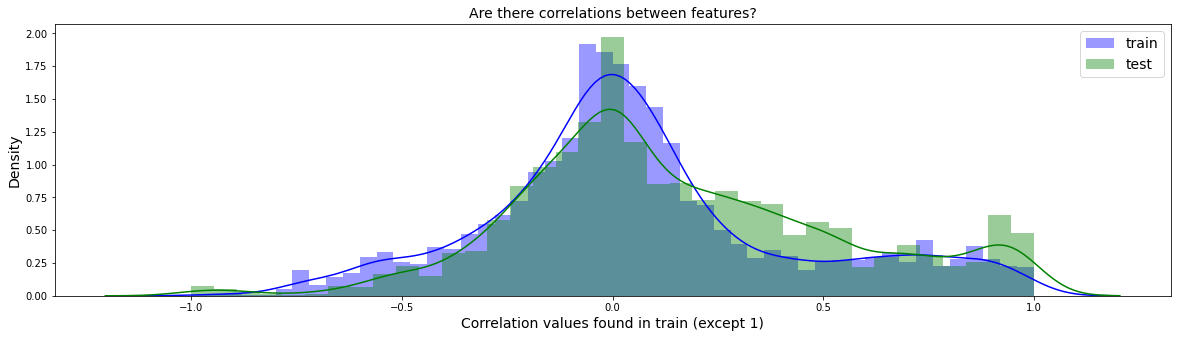

In [ ]:
train_correlations = numerical_features.corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

columns = numerical_features.columns.tolist()
columns = columns[:-4]

test_correlations = df_test[columns].corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="Blue", label="train")
sns.distplot(test_correlations, color="Green", label="test")

plt.xlabel("Correlation values found in train (except 1)", size=14)
plt.title("Are there correlations between features?", size=14)
plt.legend(loc="best", fontsize=14)
plt.ylabel("Density", size=14)

Коэффициент корреляции > 0.2 - связь между признаками присутствует

## Correlation Heat Map

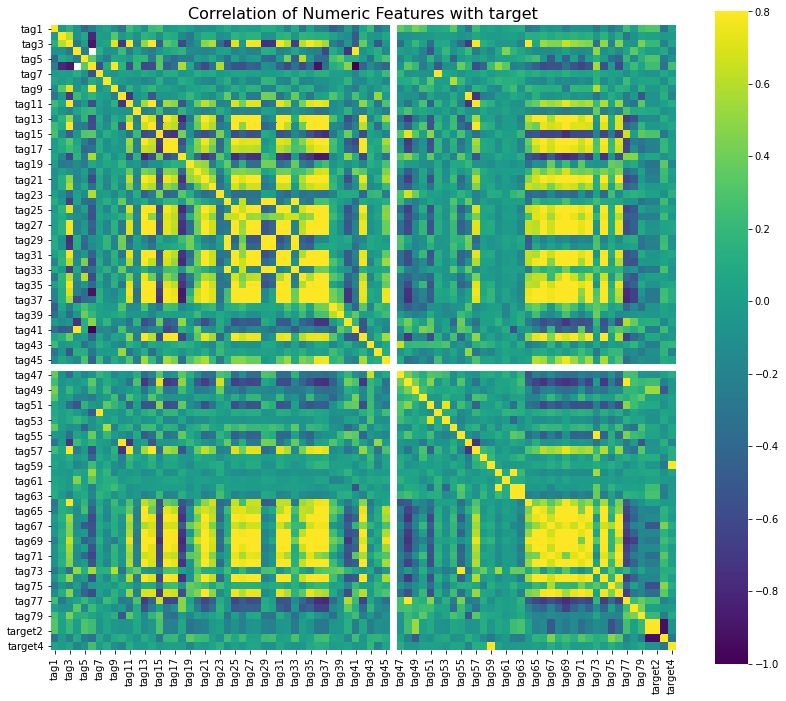

In [ ]:
fig, axes = plt.subplots(figsize = (14,12))
plt.title("Correlation of Numeric Features with target1", y=1, size=16)
sns.heatmap(correlation, square=True, vmax=0.8, cmap="viridis")

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:194: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)


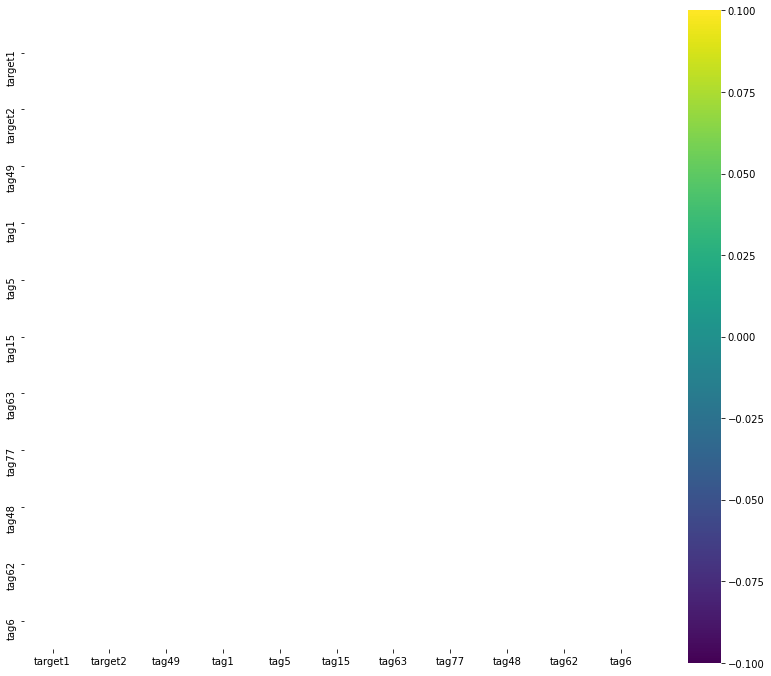

In [ ]:
k = 11
cols = correlation.nlargest(k, "target1")["target1"].index
cm = np.corrcoef(df_train[cols].values.T)
fig, axes = plt.subplots(figsize = (14, 12))

sns.heatmap(
    cm,
    vmax=.8,
    linewidths=0.01,
    cmap="viridis",
    square=True,
    annot=True,
    linecolor="white",
    xticklabels=cols.values,
    annot_kws = {"size": 12},
    yticklabels=cols.values
)

## 10 признаков, которые обладают наибольшей нелинейной связью с целевой переменной.

In [ ]:
num = numerical_features.fillna(-9999)

In [ ]:
target_1 = num["target1"]
target_2 = num["target2"]
target_3 = num["target3"]
target_4 = num["target4"]

In [ ]:
%%time
parameters = {"max_depth": 6, "n_estimators": 25, "random_state": 27, "n_jobs": 2}

forest = RandomForestRegressor(**parameters)
forest.fit(num.drop("target1", axis=1), target_1)

CPU times: user 44.4 s, sys: 12 ms, total: 44.4 s
Wall time: 23.5 s


Text(0.5, 1.0, 'What are the top important features to start with?')

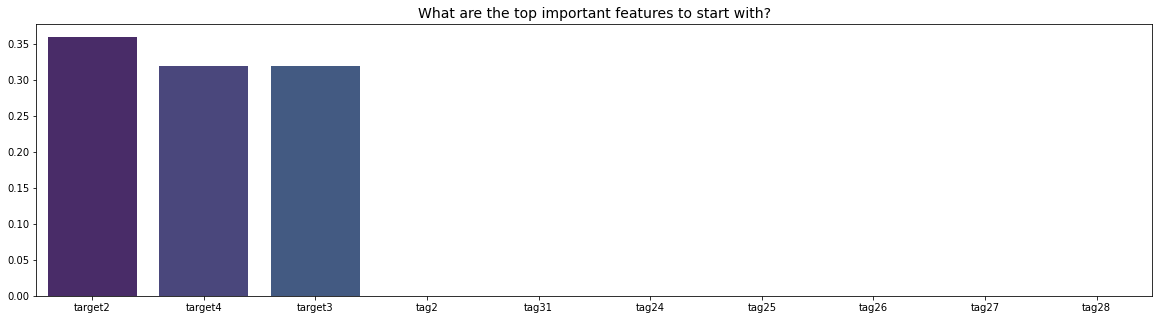

In [ ]:
n_top = 10
importances = forest.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = num.drop("target1", axis=1).columns

plt.figure(figsize=(20, 5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

Text(0.5, 1.0, 'What are the top important features to start with?')

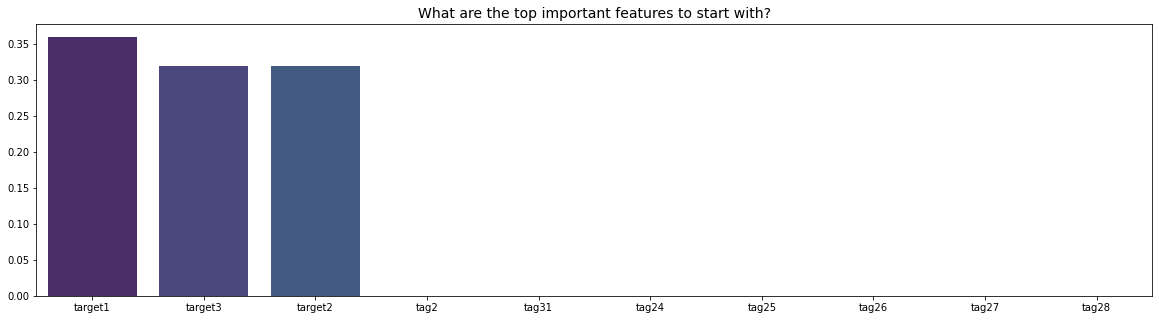

In [ ]:
n_top = 10
importances = forest.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = num.drop("target4", axis=1).columns

plt.figure(figsize=(20, 5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)